1) Use John Hopkins data by city for COVID-19 infections for a selection of cities (at least 2)
    Select cities by
    a) availability of date stay-at-home orders were issued
    b) population data availability
    c) other interest / randomness

2) Create SIR network model for COVID-19

3) Create ERGMs for periods before and after stay-at-home orders issued. These need to not just use structure or degree counts, but also propagation outputs at different periods with some statistical goodness of fit measure relative to the observed data. This area is probably the most difficult / problematic; I only know how to do an ERGM based on the direct aspects and think the computational complexity here might be a problem.

4) Compare the rates of change for the degree / structures of the resulting random graphs that fit the infection data to compare how relatively well the cities implemented social distancing.

Potential issues: <br>population density<br>ERGM parameters to train to<br>
< k><br>
< transmissibility><br>
< effective number of secondary infections><br>

number of days infection lasts can help connect r naught and transmissibility<br><br>
< k> X tau X [a proportion  of duration] = R naught<br>
    population density influences k average<br>
    
Paper to look up:<br>
    pastor-satorras, vespignani, boguña physical review (letters?)<br>
    who first described epidemics in erdos renyi graphs? (check Grassberger)<br>
    
Need clusters and social distancing outside of the clusters...<br>
    Vespignani in particular is worth looking into

http://mutex.gmu.edu/login?url=https://journals.aps.org/pre/abstract/10.1103/PhysRevE.70.056122
http://mutex.gmu.edu/login?url=https://journals.aps.org/pre/abstract/10.1103/PhysRevE.66.047104
http://mutex.gmu.edu/login?url=https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.90.028701
http://mutex.gmu.edu/login?url=https://link.springer.com/article/10.1140/epjb/e2004-00038-8

This one is promising
http://mutex.gmu.edu/login?url=https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.92.178701

http://mutex.gmu.edu/login?url=https://royalsocietypublishing.org/doi/abs/10.1098/rsbl.2004.0188
http://mutex.gmu.edu/login?url=https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.97.088701

Also promising
http://mutex.gmu.edu/login?url=https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.87.925


### ERGM

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from scipy.special import comb

In [3]:
alpha = -0.849 # 1.6
gamma = -0.51 # -1.5 1 #newly specified parameter
stop_threshold = 0.01
n = int(12)
p = float(0.15)
Q = 2200
q = 200
Tao = 10
nchoose3 = comb(n,3,exact=True)
m_list=[]
t_list=[]

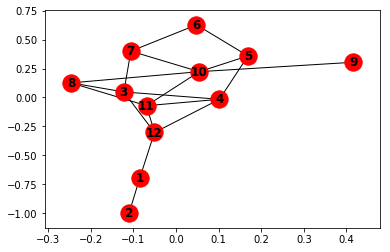

In [5]:
#def create_graph(n,p):
#    G = nx.Graph()
#    for q in range(n):
#        G.add_node(q)
#    for i in range(n):
#        for j in range(i+1,n):
#            if random.random()<p:
#                G.add_edge(i,j)
#    return(G)

def create_graph(n,p):
    G=nx.Graph()
    G.add_edges_from([(1,2),(1,12),(3,4),(3,7),(3,8),\
             (3,12),(4,5),(4,11),(4,12),(5,6),\
             (5,10),(6,7),(7,10),(8,10),(8,11),\
             (9,10),(10,11),(11,12)])
    return(G)


G = create_graph(n,p)
nx.draw_networkx(G,with_labels=True,font_weight='bold')

G_naught_m = len(G.edges()) # stopping parameter

In [11]:
def tri_count(G):
    return(sum(list(nx.triangles(G).values())))

tri_count(G)

In [13]:
def PGprime_PG(m,mp,t,tp,alpha,gamma): 
    #links, links prime, triangles, triangles prime, alpha and gamma parameters
    # e ^( (alpha * (m(G')-m(G))) + (gamma * (t(G')-t(G))))
    PGp_PG = math.exp((alpha*(mp-m)+gamma*(tp-t)))
    return(PGp_PG)

temp_m = G.number_of_edges()
temp_mp = temp_m+1
temp_t = tri_count(G)
temp_tp = temp_t+1
PGp_PG = PGprime_PG(temp_m,temp_mp,temp_t,temp_tp,alpha,gamma)
print(PGp_PG)

0.25691756610368544


In [14]:
def metropolis_step(G,alpha,gamma):
    Gp = deepcopy(G) # Create G Prime
    i = random.randint(1,len(Gp.nodes)-1)
    j = random.randint(1,len(Gp.nodes)-2)
    if j>=i:
        j+=1
    if j in Gp.neighbors(i):
        Gp.remove_edge(i,j)
    else: Gp.add_edge(i,j)
    t,tp = tri_count(G),tri_count(Gp)
    m,mp = G.number_of_edges(),Gp.number_of_edges()
    PGp_PG = PGprime_PG(m,mp,t,tp,alpha,gamma)
    if PGp_PG >= 1:
        return(Gp,1)
    else:
        accept_proba = random.random()
        if PGp_PG > accept_proba:
            return(Gp,1)
        else: 
            return(G,0)

In [15]:
def MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma): #change this function to run burn in, then to only update counter as noted below
    G=create_graph(n,p)
    initial_tri = tri_count(G)
    initial_edges = G.number_of_edges()
    count=0
    tri=0
    edge=0
    for a in range(Q): 
        G,x=metropolis_step(G,alpha,gamma) # x = acceptance of G prime
        if x==1: # only update if G prime accepted
            if a > q:
                if a%Tao==0:
                    links = G.number_of_edges()
                    m_list.append(links)
                    triangles = tri_count(G)
                    t_list.append(triangles)
                    count+=1
                    tri+=tri_count(G)
                    edge+=G.number_of_edges()
    avg_m = edge/count
    avg_t = tri/count
    return(m_list,t_list,avg_m,avg_t,initial_tri,initial_edges)

In [ ]:
def average(list_):
    temp=0
    for i in list_:
        temp+=i
    temp=temp/len(list_)
    return(temp)
def variance(list_):
    aver = average(list_)
    var = 0
    #temp_val = 0
    for i in list_:
        temp_val = (i-aver)**2
        var += temp_val
    var=var/len(list_)
    return(var,aver)
def covariance(list1,list2,m_ave,t_ave):
    #aver_prod = m_ave*t_ave
    combined = zip(list1,list2)
    temp_list = []
    for i in combined:
        temp_list.append((i[0]-m_ave)*(i[1]-t_ave))
    covar = average(temp_list)
    return(covar)